In [2]:
library(data.table)
library(ggplot2)
library(dplyr)
library(viridis)
library(qqman)

"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0



Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: viridisLite

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.



In [3]:
#check out angsd results
#hwe <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd.hwe.gz")
#setnames(hwe, 9, "p")

In [3]:
nrow(hwe)

[1] 6295180

In [73]:
nrow(hwe)

[1] 6295180

In [261]:
#plot(hwe$hweFreq, hwe$Freq) #no super obvious het problems

In [391]:
#how do maf and calls across ind look
sites <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd_probs.hwe.gz")
head(sites)

Chromo,Position,Major,Minor,hweFreq,Freq,F,LRT,p-value
CM009708.1,164,A,G,0.143948,0.143978,-0.012379,0.004032974,0.9493638
CM009708.1,479,T,A,0.098266,0.099586,-0.109246,0.309823700,0.5777884
CM009708.1,480,T,G,0.167168,0.176823,-0.214118,1.518999000,0.2177710
CM009708.1,787,C,T,0.411355,0.409284,-0.317570,0.795253300,0.3725164
CM009708.1,1492,T,G,0.122028,0.124322,-0.139868,0.466126500,0.4947746
CM009708.1,2973,C,T,0.096377,0.099344,-0.109185,0.381258200,0.5369306


In [396]:
unlinked <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_unlinked_for_angsd.txt")
setnames(unlinked, 1:2, c("Chromo", "Position"))
unlinked[, filter := 1]

In [397]:
head(unlinked)

Chromo,Position,filter
CM009708.1,10000697,1
CM009708.1,10003708,1
CM009708.1,10003879,1
CM009708.1,10004338,1
CM009708.1,10004540,1
CM009708.1,10007683,1


In [398]:
test_filter_sites <- left_join(sites, unlinked)
head(test_filter_sites)

Joining, by = c("Chromo", "Position")


Chromo,Position,Major,Minor,hweFreq,Freq,F,LRT,p-value,filter
CM009708.1,164,A,G,0.143948,0.143978,-0.012379,0.004032974,0.9493638,1
CM009708.1,479,T,A,0.098266,0.099586,-0.109246,0.309823700,0.5777884,NA
CM009708.1,480,T,G,0.167168,0.176823,-0.214118,1.518999000,0.2177710,1
CM009708.1,787,C,T,0.411355,0.409284,-0.317570,0.795253300,0.3725164,1
CM009708.1,1492,T,G,0.122028,0.124322,-0.139868,0.466126500,0.4947746,1
CM009708.1,2973,C,T,0.096377,0.099344,-0.109185,0.381258200,0.5369306,1


In [399]:
nrow(test_filter_sites)==nrow(sites)

[1] TRUE

In [400]:
test_filter_sites[is.na(filter), filter := 0]

In [401]:
head(test_filter_sites)

Chromo,Position,Major,Minor,hweFreq,Freq,F,LRT,p-value,filter
CM009708.1,164,A,G,0.143948,0.143978,-0.012379,0.004032974,0.9493638,1
CM009708.1,479,T,A,0.098266,0.099586,-0.109246,0.309823700,0.5777884,0
CM009708.1,480,T,G,0.167168,0.176823,-0.214118,1.518999000,0.2177710,1
CM009708.1,787,C,T,0.411355,0.409284,-0.317570,0.795253300,0.3725164,1
CM009708.1,1492,T,G,0.122028,0.124322,-0.139868,0.466126500,0.4947746,1
CM009708.1,2973,C,T,0.096377,0.099344,-0.109185,0.381258200,0.5369306,1


In [402]:
fwrite(test_filter_sites[,.(filter)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/filter_linked_sites_pcangsd.txt", col.names = F)

In [266]:
#how many snps on each chrom
nrow(maf[, .N, by="chromo"])
names <- maf[, .N, by="chromo"][, "chromo"]
head(names)
#fwrite(names, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/ngsld/chromosomes.txt", col.names =F)

[1] 227

chromo
1
2
3
4
5
6


In [265]:
#hist(maf$nInd)
#hist(maf$knownEM)

In [259]:
#hist(maf[knownEM < 0.1, nInd]) #for the really low maf, what's the distribution of individuals the snp was found in? make sure the nInd GL filter worked as expected

In [16]:
6295181/5886701


[1] 1.06939

In [ ]:
#plot the pcangsd results, color by phenotypes in the association

In [403]:
pca <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd_probs.beagle.pcangsd.cov")

In [404]:
dim(pca)

[1] 159 159

In [405]:
#get eigenvalues
ev <-eigen(pca)
ev_dt <- data.table(ev$vectors[,1:10])
setnames(ev_dt, c("pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10"))

In [406]:
#variance explained?
ev$values/sum(ev$values)

[1] 0.124567366 0.005950620 0.005946557 0.005934197 0.005923810 0.005923153
  [7] 0.005921266 0.005920494 0.005919755 0.005912821 0.005909094 0.005902407
 [13] 0.005901325 0.005894644 0.005891839 0.005885254 0.005883745 0.005830649
 [19] 0.005829631 0.005828509 0.005827635 0.005824809 0.005802459 0.005797809
 [25] 0.005796255 0.005789794 0.005782484 0.005780938 0.005776707 0.005774031
 [31] 0.005771802 0.005765432 0.005758927 0.005757834 0.005756980 0.005754302
 [37] 0.005741452 0.005736543 0.005734595 0.005732662 0.005730133 0.005727078
 [43] 0.005717113 0.005707010 0.005704144 0.005697941 0.005696983 0.005690128
 [49] 0.005673555 0.005664961 0.005662118 0.005656399 0.005646614 0.005636550
 [55] 0.005633001 0.005626290 0.005620419 0.005607996 0.005600200 0.005599716
 [61] 0.005590771 0.005587972 0.005584886 0.005578741 0.005575615 0.005568706
 [67] 0.005568420 0.005567264 0.005565624 0.005562684 0.005558825 0.005557987
 [73] 0.005555041 0.005550932 0.005544993 0.005532910 0.005529153 0.005524596
 [79] 0.005523163 0.005521574 0.005519051 0.005517305 0.005509342 0.005503960
 [85] 0.005502106 0.005500493 0.005498215 0.005497428 0.005495823 0.005494346
 [91] 0.005491870 0.005490665 0.005486375 0.005484789 0.005480273 0.005477595
 [97] 0.005475996 0.005474945 0.005473966 0.005473278 0.005470083 0.005468672
[103] 0.005467553 0.005464878 0.005459840 0.005457078 0.005455848 0.005453159
[109] 0.005446282 0.005439893 0.005435550 0.005433827 0.005429790 0.005428718
[115] 0.005423836 0.005418768 0.005410906 0.005405932 0.005403365 0.005395555
[121] 0.005389082 0.005382510 0.005373013 0.005370224 0.005361076 0.005359713
[127] 0.005359287 0.005356832 0.005347166 0.005328756 0.005326882 0.005323379
[133] 0.005308876 0.005287843 0.005275775 0.005274878 0.005270757 0.005262808
[139] 0.005260521 0.005250888 0.005249857 0.005243368 0.005237847 0.005236299
[145] 0.005231784 0.005231211 0.005229872 0.005228921 0.005226736 0.005223296
[151] 0.005220854 0.005205388 0.005195945 0.005192983 0.005184731 0.005183066
[157] 0.005162142 0.005056235 0.004583054

In [204]:
#bamlist <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/bamlist.list.txt")
meta <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0][, .(sample=gen_id, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]

#case_control_pheno <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_pheno.ybin")
#setnames(case_control_pheno, "case")
#sl_pheno <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/SL_pheno.ybin")
#setnames(sl_pheno, "sl")
#ucrit_pheno <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Ucrit_pheno.ybin")
#setnames(ucrit_pheno, "ucrit")

In [10]:
head(meta)

sample,ucrit,sl,dam,sire,case,capture
Pop01_APPC1611,8.13,4.40,D125,S144,1,Pop01
Pop01_APPC1917,1.20,4.35,D85,S173,0,Pop01
Pop01_APPC1921,7.33,4.28,D85,S173,1,Pop01
Pop01_APPC2029,8.82,4.25,D70,S98,1,Pop01
Pop01_APPC2030,7.32,4.54,D70,S98,1,Pop01
Pop01_APPC2101,5.07,3.94,D269,S94,1,Pop01


In [ ]:
#meta[, bam_id := paste(Capture, larvalID, sep="_")] #make a name column consistent with bamlist
#join with bamlist
#bam_meta <- left_join(bamlist, meta, by=c(sample="gen_id"))[, .(sample, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]

In [ ]:
#check that the angsd assoc phenotypes were in the right order
#(bam_meta$case==case_control_pheno$case)
#(bam_meta$ucrit== ucrit_pheno$ucrit)
#(bam_meta$sl== sl_pheno$sl)

In [407]:
pca_phenos <- cbind(meta , ev_dt)[, sequencing_lib := ifelse(capture %in% c("Pop01","Pop02","Pop03", "Pop04", "Pop05", "Pop06", "Pop07","Pop08"), 1, 2)]

In [408]:
head(pca_phenos)


sample,ucrit,sl,dam,sire,case,capture,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,sequencing_lib
Pop01_APPC1611,8.13,4.40,D125,S144,1,Pop01,-0.091565420,-0.004939105,-0.002686270,-5.062898e-04,5.998697e-05,-4.184335e-05,9.057768e-05,-1.479103e-04,-2.135865e-04,-5.174197e-04,1
Pop01_APPC1917,1.20,4.35,D85,S173,0,Pop01,-0.116673430,-0.006175060,-0.002988189,-4.050871e-04,2.943136e-04,-1.332973e-04,-1.166735e-04,-8.922913e-05,-4.047281e-05,-4.050558e-04,1
Pop01_APPC1921,7.33,4.28,D85,S173,1,Pop01,0.001539587,0.001758076,-0.001468365,8.874239e-04,3.736911e-05,-9.185312e-03,-2.439356e-02,-9.983102e-01,5.096173e-02,-8.013393e-05,1
Pop01_APPC2029,8.82,4.25,D70,S98,1,Pop01,-0.055120023,-0.002264812,-0.002080216,-2.511301e-05,-1.452518e-04,-2.515533e-04,-5.207540e-03,4.584080e-05,1.327576e-04,-1.887562e-03,1
Pop01_APPC2030,7.32,4.54,D70,S98,1,Pop01,0.016379895,0.007483771,0.001512953,1.697870e-03,1.428538e-03,6.359939e-04,-3.826000e-04,6.341601e-04,4.695597e-04,1.685231e-03,1
Pop01_APPC2101,5.07,3.94,D269,S94,1,Pop01,0.083303403,0.003833755,0.034647041,3.936080e-04,-1.082421e-04,2.363064e-04,-4.425574e-04,2.268637e-04,1.499853e-04,-1.375006e-04,1


In [50]:
ForAngsdGWAS <- pca_phenos[, .(sample, phe1=ucrit, phe2=sl, phe3=case, cov1=pc1)]

In [40]:
#fwrite(ForAngsdGWAS, "~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ForAngsdGWAS.sample", sep=",")

In [215]:
#fwrite(pca[, 1:10], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/pc1-10.cov")

In [214]:
dim(pca[, 1:10])

[1] 159  10

In [207]:
plot(pca)

ERROR: Error in plot.new(): figure margins too large


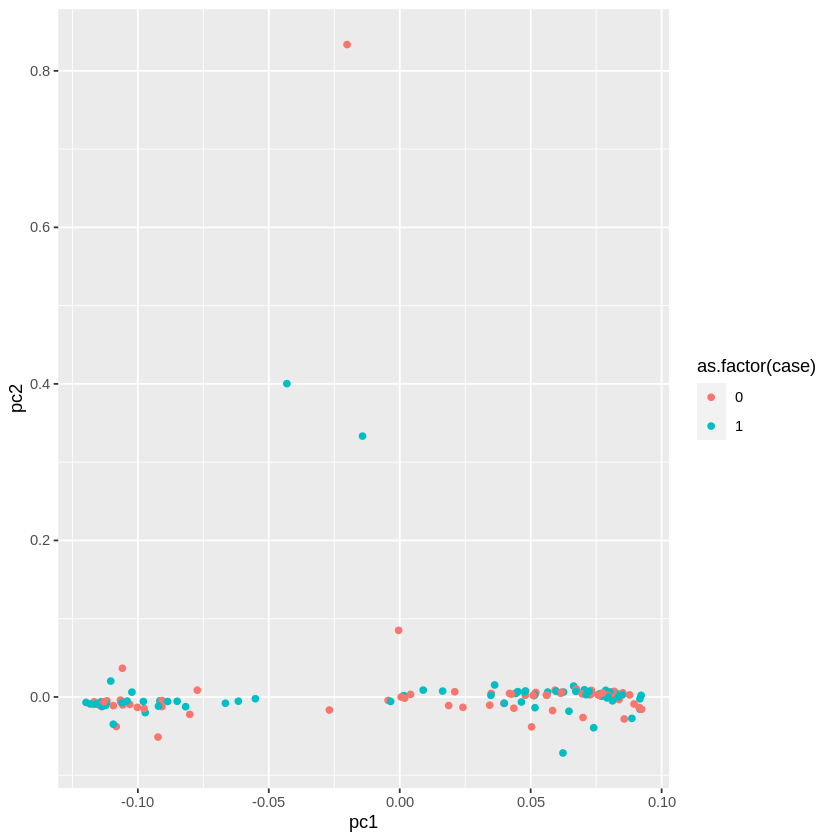

In [409]:
ggplot()+
    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=as.factor(case)))

In [112]:
#ggplot()+
#    geom_point(data=pca_phenos[], aes(x=pc1, y=pc2, col=sl)) +
#    scale_color_viridis(color.palette=magma)

In [111]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=ucrit)) +
#    scale_color_viridis(option="magma")

In [110]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=sequencing_lib)) +
#    scale_color_viridis(option="magma")

In [109]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=capture)) 

# plot GWAS results

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,pvalue_corr



Call:
qvalue(p = lrt_filt[pvalue < 1, pvalue])

pi0:	0.4158607	

Cumulative number of significant calls:

          <1e-04 <0.001 <0.01 <0.025 <0.05  <0.1     <1
p-value        6     90  1341   4073  9157 20064 134124
q-value        0      0     0      0     0     0 134124
local FDR      0      0     0      0     0     0 134030



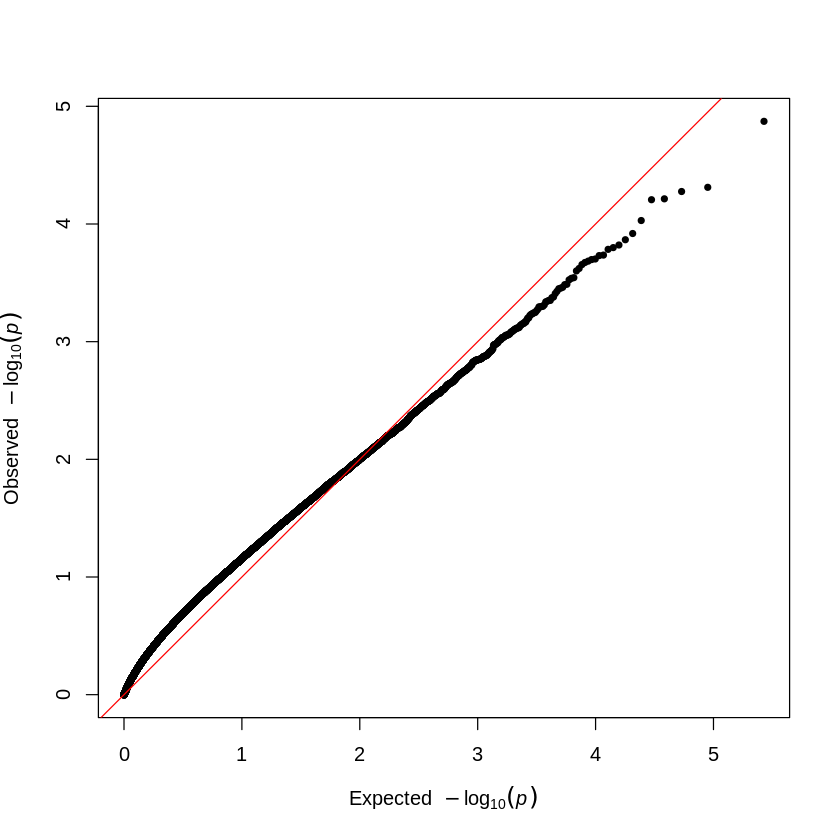

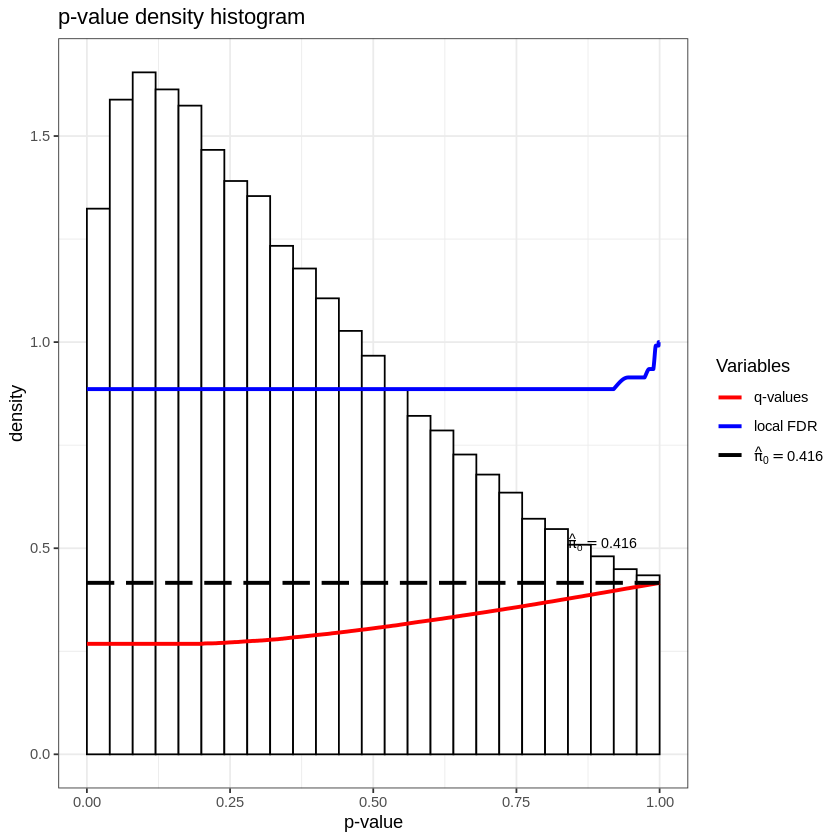

In [410]:
#read in hwe results 
hwe <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ensembl_appc_angsd_probs_doGeno8.hwe.gz")
setnames(hwe, 9, "p")
#make a locus column 
hwe[, locus := paste(Chromo, Position, sep=":")]

#read in the gwas results
lrt <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/bin_doAssoc2.lrt0.gz")
#make a locus column 
lrt[, locus := paste(Chromosome, Position, sep=":")]
#filter out loci in hwe and NAN
lrt_filt <- lrt[locus %!in% hwe[p < 0.05, locus]][LRT>0]

#format for manhattan plot
#get pvalues
lrt_filt$pvalue<-dchisq(lrt_filt$LRT, df=1)
#lrt_filt[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
#lrt_filt[, Chromosome := as.numeric(Chromosome)]
lrt_filt$SNP<-paste("r",1:length(lrt_filt$Chromosome), sep="")

# For p-values, calculate chi-squared statistic
#lrt_filt[,chisq := qchisq(1-pvalue,1)]
#chsq <- (lrt_filt[!is.nan(chisq), chisq])

#Calculate GIF, lambda gc (λgc)
#median(chsq, na.rm = T)/qchisq(0.5,1)
#plot model fit
qqman::qq(lrt_filt$pvalue) 
#lrt_filt[order(pvalue)][1:10]
#lrt_filt[order(pvalue)][pvalue <1e-6, SNP]

#use q value
lrt_filt[, pvalue_corr := ifelse(pvalue >1, 1, pvalue)]

qobj <- qvalue(lrt_filt[pvalue <1 ,pvalue]) #can adjust fdr here
qobj_fdrlevel <- qvalue(p = lrt_filt[pvalue <1 ,pvalue], fdr.level = 0.1)
signif <- which(qobj_fdrlevel$significant==TRUE)
#signif <- which(qobj$significant==TRUE)
lrt_filt[pvalue < 1][signif,][order(pvalue)]

#qvalues <- qobj$qvalues
pi0 <- qobj$pi0
#lfdr <- qobj$lfdr

summary(qobj)
hist(qobj)
#plot(qobj)

In [363]:
qobj_fdrlevel <- qvalue(p = lrt_filt[pvalue <1 ,pvalue], fdr.level = 0.1)

In [364]:
signif <- which(qobj_fdrlevel$significant==TRUE)

In [366]:
lrt[locus=="11:27595087"]
#11:27595087 
#2:16016301

Chromosome,Position,Major,Minor,Frequency,LRT,locus
11,27595087,C,T,0.399784,29.15078,11:27595087


In [365]:
lrt_filt[pvalue < 1][signif,][order(pvalue)]


Chromosome,Position,Major,Minor,Frequency,LRT,locus,pvalue,SNP,pvalue_corr
11,27595087,C,T,0.399784,29.15078,11:27595087,3.455997e-08,r3552019,3.455997e-08
2,16016301,A,T,0.420916,27.49578,2:16016301,8.140381e-08,r457967,8.140381e-08


In [316]:
bin_doAssoc2_pca1_qobj <- qobj

In [305]:
max(qvalues[qobj$pvalues <= 0.01])


[1] 2.491513

In [270]:
lrt_filt[order(pvalue)][1:10]
lrt_filt[order(pvalue)][pvalue <1e-6, SNP]

Chromosome,Position,Major,Minor,Frequency,LRT,locus,pvalue,SNP,chisq
11,27595087,C,T,0.399784,29.15078,11:27595087,3.455997e-08,r3552019,30.43299
2,16016301,A,T,0.420916,27.49578,2:16016301,8.140381e-08,r457967,28.77238
12,25058095,A,T,0.277069,25.12561,12:25058095,2.785450e-07,r3841192,26.39302
23,653787,C,T,0.154713,24.16069,23:653787,4.601800e-07,r6650841,25.42391
6,37957666,C,G,0.391876,23.59117,6:37957666,6.191233e-07,r1952932,24.85176
3,28234957,C,T,0.437653,23.30957,3:28234957,7.170255e-07,r896806,24.56882
16,3558599,C,G,0.423649,22.73351,16:3558599,9.684058e-07,r4859363,23.98994
22,13747328,A,G,0.415023,22.58004,22:13747328,1.049188e-06,r6516766,23.83569
8,38909563,T,C,0.419653,22.48597,8:38909563,1.102015e-06,r2621184,23.74114
22,13747327,G,C,0.429689,21.60591,22:13747327,1.745662e-06,r6516765,22.85641


[1] "r3552019" "r457967"  "r3841192" "r6650841" "r1952932" "r896806"  "r4859363"

In [388]:
lrt <-  fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/bin_doAssoc1.lrt0.gz")

Warning message in fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/bin_doAssoc1.lrt0.gz"):
“Discarded single-line footer: <<14	30840224	G	A	0.248>>”

In [390]:
nrow(lrt)

[1] 4489370

In [369]:
maf[chromo=="11" & position=="27595087"]
#11:27595087 
#2:16016301

chromo,position,major,minor,knownEM,pK-EM,nInd
11,27595087,C,T,0.399784,0,26


In [368]:
head(maf)

chromo,position,major,minor,knownEM,pK-EM,nInd
1,164,A,G,0.144025,4.856635e-08,28
1,479,T,A,0.098202,4.630796e-10,34
1,480,T,G,0.167226,5.107026e-14,33
1,529,C,A,0.168935,0.000000e+00,65
1,787,C,T,0.411443,0.000000e+00,23
1,1492,T,G,0.121895,5.118461e-11,38


In [272]:
library("qvalue")
#install_github("jdstorey/qvalue")

In [294]:
nrow(lrt_filt[pvalue <1])/nrow(lrt_filt)

[1] 0.7100073

In [296]:
chsq <- (lrt_filt[pvalue <1 & !is.nan(chisq), chisq])

#Calculate GIF, lambda gc (λgc)
median(chisq, na.rm = T)/qchisq(0.5,1)

[1] 2.678992

In [373]:
lrt <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/bin_doAssoc2_minHigh30_pc1.lrt0.gz")
summary(lrt$LRT)


ERROR: Error in fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/bin_doAssoc2_minHigh30_pc1.lrt0.gz"): Internal error: sampleLines(101) > allocnrow(0)


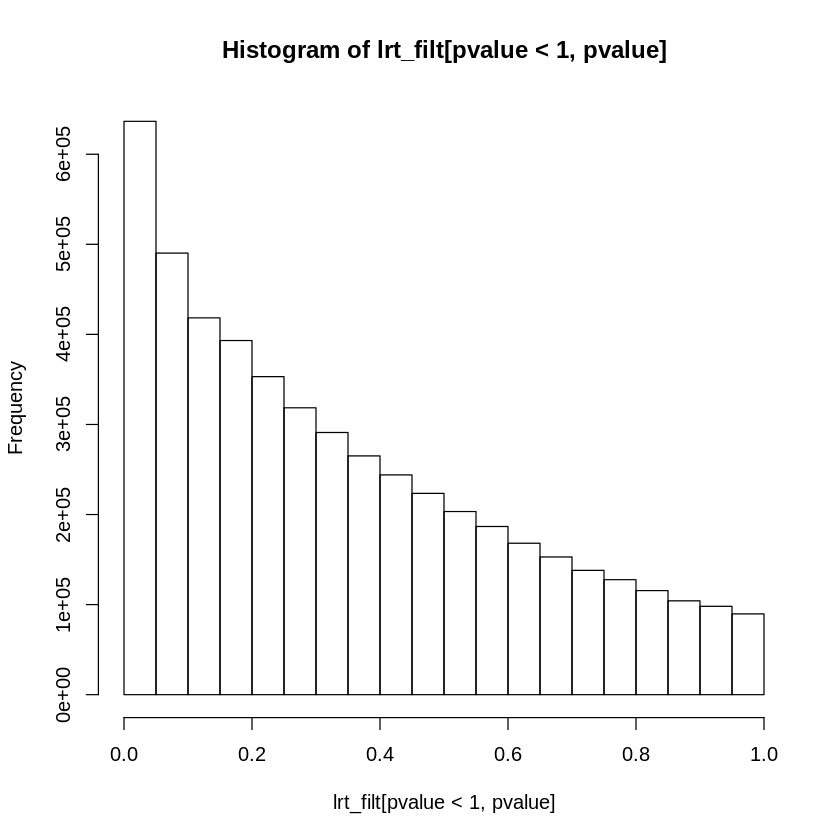

In [293]:
hist(lrt_filt[pvalue <1, pvalue])

In [302]:
bin_doAssoc1_pca1_10_minHigh30_qobj <- qobj

In [285]:
#qobj <- qvalue(p = pvalues)
qvalues <- qobj$qvalues
pi0 <- qobj$pi0
lfdr <- qobj$lfdr

In [298]:
summary(qobj)


Call:
qvalue(p = lrt_filt[pvalue < 1, pvalue])

pi0:	0.3404586	

Cumulative number of significant calls:

          <1e-04 <0.001  <0.01 <0.025  <0.05    <0.1      <1
p-value      832  10841 130337 337815 636550 1126799 5017801
q-value        0      0      0      0      0       2 5017801
local FDR      0      0      0      0      1       1 5013374



In [288]:
hist(qobj)


Call:
qvalue(p = lrt_filt[pvalue < 1, pvalue])

pi0:	0.3404586	

Cumulative number of significant calls:

          <1e-04 <0.001  <0.01 <0.025  <0.05    <0.1      <1
p-value      832  10841 130337 337815 636550 1126799 5017801
q-value        0      0      0      0      0       2 5017801
local FDR      0      0      0      0      1       1 5013374



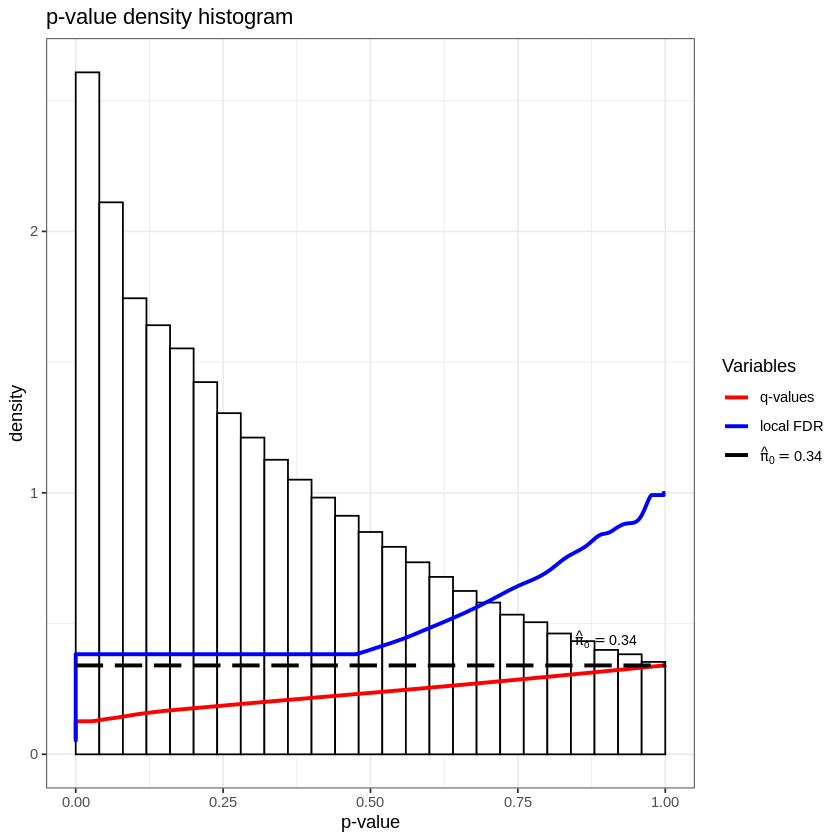

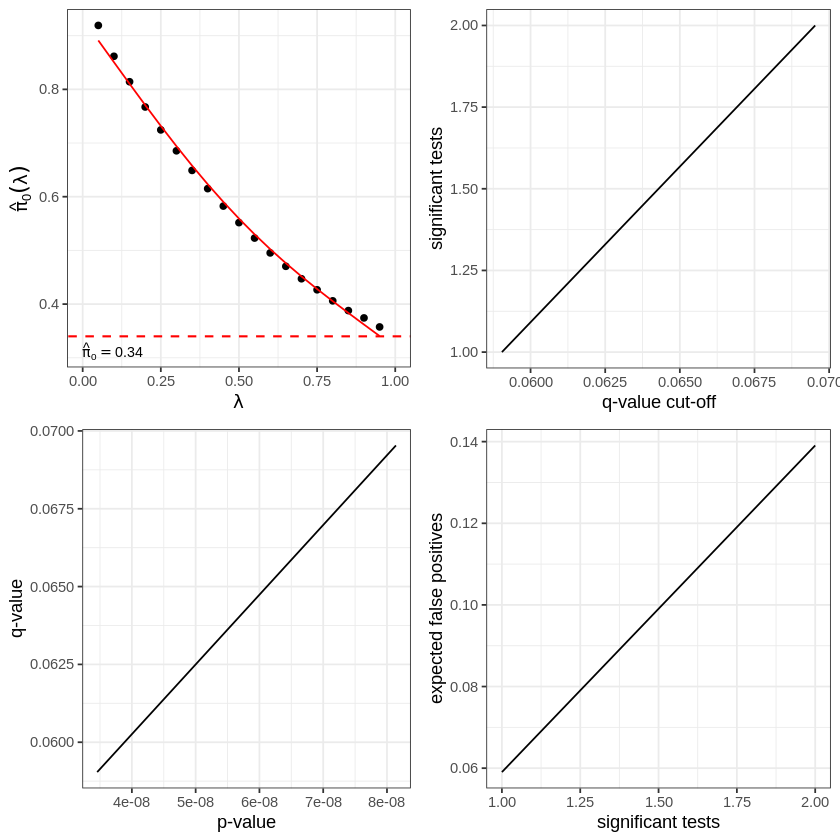

In [299]:
summary(qobj)
hist(qobj)
plot(qobj)

In [ ]:
qobj$lfdr

In [278]:
head(lrt_filt)

Chromosome,Position,Major,Minor,Frequency,LRT,locus,pvalue,SNP,chisq,pvalue_corr
1,164,A,G,0.144025,1.171608,1:164,0.2051670,r1,1.6052062,0.2051670
1,479,T,A,0.098202,0.255226,1:479,0.6950659,r2,0.1536558,0.6950659
1,480,T,G,0.167226,0.117581,1:480,1.0970062,r3,NaN,1.0000000
1,529,C,A,0.168935,0.125478,1:529,1.0577403,r4,NaN,1.0000000
1,787,C,T,0.411443,0.743850,1:787,0.3188911,r5,0.9934891,0.3188911
1,1492,T,G,0.121895,0.054658,1:1492,1.6604063,r6,NaN,1.0000000


In [131]:
#check out ld results
ld <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_unlinked.id")
head(ld)
setnames(ld, 1, "site")

#site1
CM009708.1:10000697
CM009708.1:10003708
CM009708.1:10003879
CM009708.1:10004338
CM009708.1:10004540
CM009708.1:10007683


In [133]:
test_with_unlinked <- no_hwe_lrt_filt[locus %in% ld[,site]]

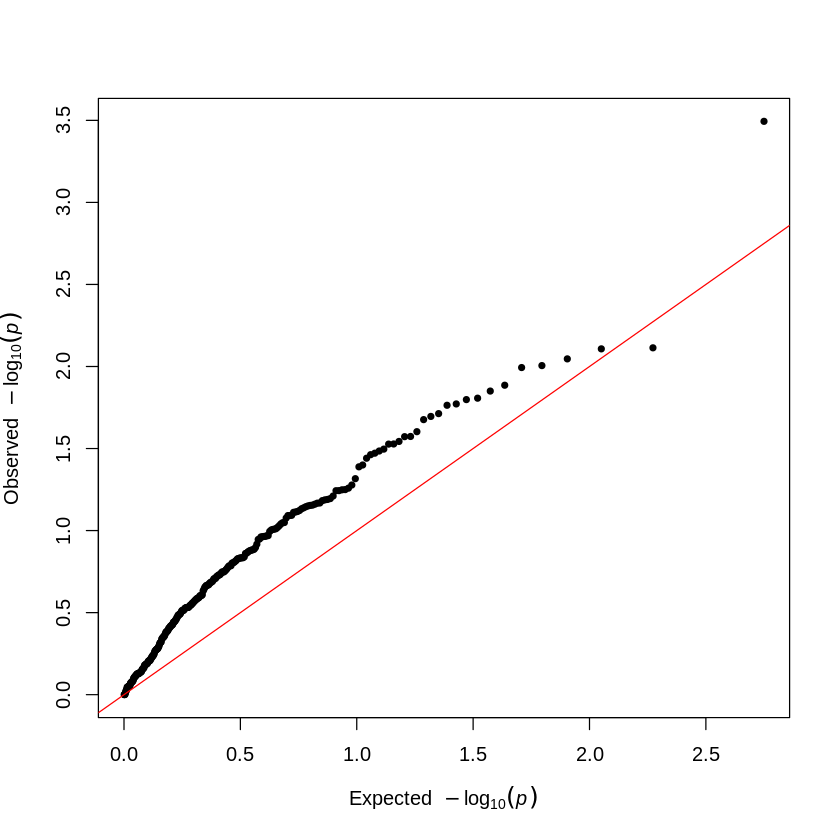

In [134]:
qqman::qq(test_with_unlinked$pvalue) 

In [10]:
#What's the highest pvalue we get with the permuted phenotypes?
case_control_lrt_NULL <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out_NULL.lrt0.gz")
case_control_lrt_NULL[, locus := paste(Chromosome, Position, sep=":")]
no_hwe_lrt_NULL <- case_control_lrt_NULL[locus %!in% case_control_hwe[p < 0.05, locus]]
nrow(no_hwe_lrt_NULL) == nrow(no_hwe_lrt) #should be true

#filter other sites that have negative LRT
no_hwe_lrt_filt_NULL<-no_hwe_lrt_NULL[LRT >0]
nrow(no_hwe_lrt_filt_NULL) #number of sites included
no_hwe_lrt_filt_NULL$pvalue<-dchisq(no_hwe_lrt_filt_NULL$LRT, df=1)
summary(no_hwe_lrt_filt_NULL$pvalue)

Warning message in fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out_NULL.lrt0.gz"):
“Discarded single-line footer: <<CM00972>>”

[1] FALSE

[1] 4415623

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.1636   0.4526   2.0543   1.1442 398.9421 

In [11]:
min(no_hwe_lrt_filt_NULL$pvalue)
min(no_hwe_lrt_filt$pvalue)

[1] 1.358339e-06

[1] 3.455997e-08

In [76]:
candidates <- no_hwe_lrt_filt[LRT > max(case_control_lrt_NULL$LRT)]

In [77]:
no_hwe_lrt_filt[pvalue < min(no_hwe_lrt_filt_NULL$pvalue)]

Chromosome,Position,Major,Minor,Frequency,LRT,locus,pvalue,SNP
97091,16016301,A,T,0.420916,27.49578,CM009709.1:16016301,8.140381e-08,r457958
97101,28234957,C,T,0.437653,23.30957,CM009710.1:28234957,7.170255e-07,r896790
97131,37957666,C,G,0.391876,23.59117,CM009713.1:37957666,6.191233e-07,r1952891
97151,38909563,T,C,0.419653,22.48597,CM009715.1:38909563,1.102015e-06,r2621157
97181,27595087,C,T,0.399784,29.15078,CM009718.1:27595087,3.455997e-08,r3551971
97191,25058095,A,T,0.277069,25.12561,CM009719.1:25058095,2.785450e-07,r3841142
97231,3558599,C,G,0.423649,22.73351,CM009723.1:3558599,9.684058e-07,r4859309
97291,13747328,A,G,0.415023,22.58004,CM009729.1:13747328,1.049188e-06,r6516672
97301,653787,C,T,0.154713,24.16069,CM009730.1:653787,4.601800e-07,r6650740


In [79]:
#fwrite(candidates, "~/ClownfishGWAS/script_output/Prelim_Case_Control_Candidates.tsv", sep="\t")

In [81]:
#check out ld results
ld <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_ngsLD.tsv")
head(ld)
setnames(ld, 7, "r")

Avoidable 343.346 seconds. This file is very unusual: it ends abruptly without a final newline, and also its size is a multiple of 4096 bytes. Please properly end the last row with a newline using for example 'echo >> file' to avoid this  time to copy.


Warning message in fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_ngsLD.tsv"):
“Discarded single-line footer: <<CM009709.1:38260486	CM009709.1:38311636	51150	0.015748	->>”

In [83]:
head(ld)
setnames(ld, 7, "r")

#site1,site2,dist,r^2_ExpG,D,D',r^2
CM009708.1:787,CM009708.1:1492,705,0.022680,-0.041183,0.855414,0.067845
CM009708.1:4552,CM009708.1:4553,1,0.739407,0.164141,0.995743,0.984979
CM009708.1:9418,CM009708.1:10288,870,0.069655,0.041926,0.436036,0.078178
CM009708.1:480,CM009708.1:787,307,0.008322,-0.059842,0.876247,0.108963
CM009708.1:7589,CM009708.1:9342,1753,0.023924,0.048033,0.998856,0.253766
CM009708.1:9389,CM009708.1:9418,29,0.233455,0.174339,0.999851,0.797097


In [84]:
head(ld)


#site1,site2,dist,r^2_ExpG,D,D',r
CM009708.1:787,CM009708.1:1492,705,0.022680,-0.041183,0.855414,0.067845
CM009708.1:4552,CM009708.1:4553,1,0.739407,0.164141,0.995743,0.984979
CM009708.1:9418,CM009708.1:10288,870,0.069655,0.041926,0.436036,0.078178
CM009708.1:480,CM009708.1:787,307,0.008322,-0.059842,0.876247,0.108963
CM009708.1:7589,CM009708.1:9342,1753,0.023924,0.048033,0.998856,0.253766
CM009708.1:9389,CM009708.1:9418,29,0.233455,0.174339,0.999851,0.797097


In [86]:
nrow(ld[r >.5])/nrow(ld)

[1] 0.03217352

In [29]:
install.packages("RAINBOWR")

also installing the dependencies ‘RcppGSL’, ‘rprojroot’, ‘RcppZiggurat’, ‘pbmcapply’, ‘optimx’, ‘pegas’, ‘rrBLUP’, ‘here’, ‘Rfast’, ‘gaston’, ‘MM4LMM’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [55]:
for_FDR <- (no_hwe_lrt_filt[, .(SNP, Chromosome, Position, adj_pvalue=-log10(pvalue))])[adj_pvalue >0]

In [67]:
head(for_FDR)
head(no_hwe_lrt_filt)

SNP,Chromosome,Position,adj_pvalue
r1,97081,164,0.6878925
r2,97081,479,0.1579740
r5,97081,787,0.4963576
r7,97081,1623,0.2067779
r8,97081,1742,0.3782474
r10,97081,1830,0.2581367


Chromosome,Position,Major,Minor,Frequency,LRT,locus,pvalue,SNP
97081,164,A,G,0.144025,1.171608,CM009708.1:164,0.2051670,r1
97081,479,T,A,0.098202,0.255226,CM009708.1:479,0.6950659,r2
97081,480,T,G,0.167226,0.117581,CM009708.1:480,1.0970062,r3
97081,529,C,A,0.168935,0.125478,CM009708.1:529,1.0577403,r4
97081,787,C,T,0.411443,0.743850,CM009708.1:787,0.3188911,r5
97081,1492,T,G,0.122078,0.052974,CM009708.1:1492,1.6880120,r6


In [57]:
summary(for_FDR$adj_pvalue)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2746  0.5473  0.6758  0.9394  7.4614 

In [58]:
CalcThreshold(for_FDR, sig.level = 0.01, method = "BH")

BH_0.01 
     NA

In [45]:
nrow(no_hwe_lrt_filt[LRT > 2.85827730981295])

[1] 708151

In [ ]:
#calculate the Genomic inflation factor to check 
chisq <- qchisq(1 - pvalue, 1)
lambda <- median(chisq) / qchisq(0.5, 1)

SE.median <- qchisq(0.975, 1) * (1.253 * ( sd(chisq) / sqrt( length(chisq) ) ) )

In [65]:
gw <- -log10(min(no_hwe_lrt_filt_NULL$pvalue))

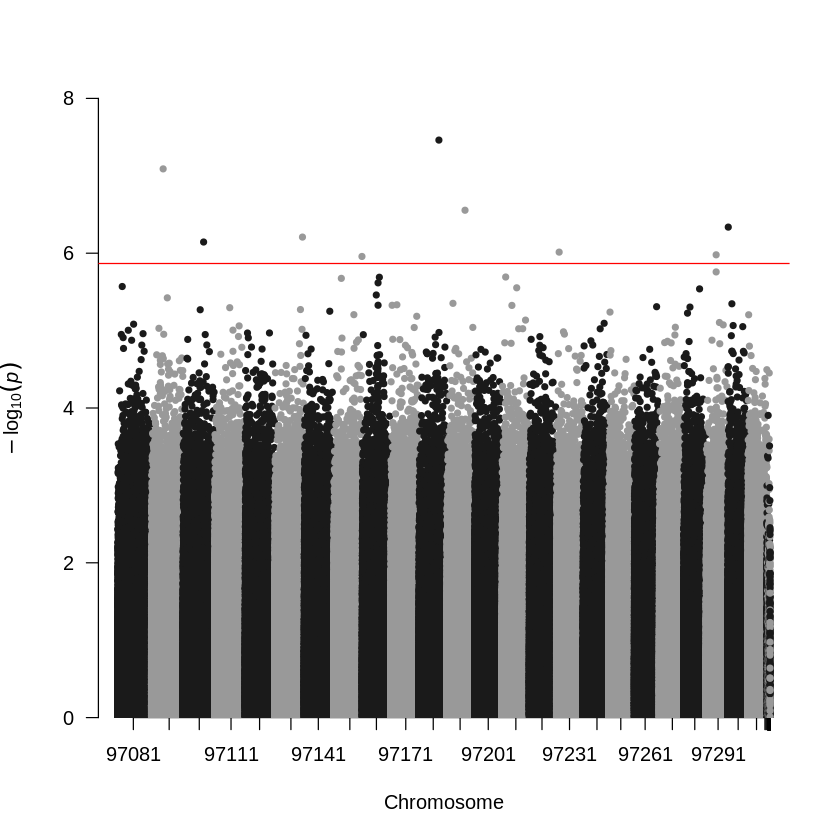

In [72]:
library(qqman)
man <- qqman::manhattan(no_hwe_lrt_filt, chr="Chromosome", bp="Position", p="pvalue", genomewideline = gw, suggestiveline = F)

In [80]:
jpeg("~/ClownfishGWAS/script_output/figures/Case_control_manhattan.jpeg")
qqman::manhattan(no_hwe_lrt_filt, chr="Chromosome", bp="Position", p="pvalue", genomewideline = gw, suggestiveline = F)
dev.off()

png 
  2

In [63]:
no_hwe_lrt_filt[pvalue <0.05]

Chromosome,Position,Major,Minor,Frequency,LRT,locus,pvalue,SNP
97081,3568,A,G,0.201610,3.678422,CM009708.1:3568,0.033061313,r28
97081,3920,C,G,0.072581,3.572991,CM009708.1:3920,0.035361361,r35
97081,10004,A,G,0.110801,6.085021,CM009708.1:10004,0.007716734,r62
97081,15239,A,C,0.230639,7.384629,CM009708.1:15239,0.003657581,r88
97081,26182,A,C,0.035331,6.285202,CM009708.1:26182,0.006869675,r111
97081,30691,G,C,0.358063,3.920331,CM009708.1:30691,0.028376553,r135
97081,31854,A,G,0.184224,3.530068,CM009708.1:31854,0.036347455,r139
97081,32326,T,C,0.258247,3.763847,CM009708.1:32326,0.031317356,r148
97081,33490,A,G,0.117639,4.309785,CM009708.1:33490,0.022275340,r200
97081,34051,G,T,0.175116,4.770738,CM009708.1:34051,0.016813754,r217


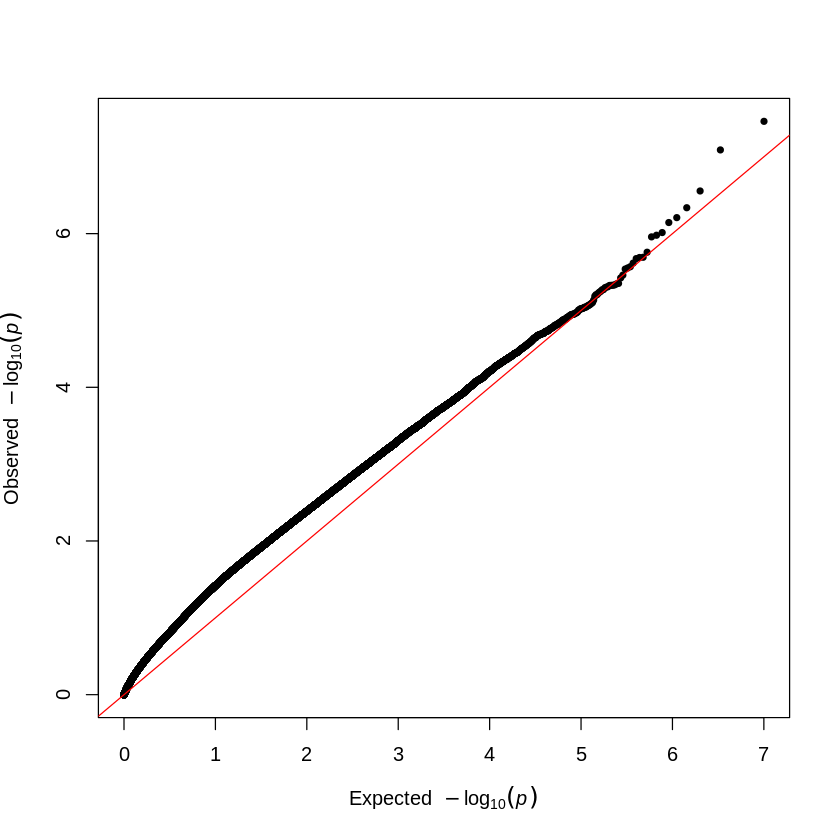

In [73]:
#library(qqman)
qq_case_control <- qqman::qq(no_hwe_lrt_filt$pvalue) 

In [12]:
summary(no_hwe_lrt_filt_NULL$pvalue)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.1636   0.4526   2.0543   1.1442 398.9421 

In [61]:
-log10(min(no_hwe_lrt_filt_NULL$pvalue))

[1] 5.866992

In [99]:
#how does it look if we exclude linked loci found so far with ngsLD
unlinked <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_unlinked.id")
setnames(unlinked, 1, "site")

In [100]:
head(unlinked)

site
CM009708.1:10000697
CM009708.1:10003708
CM009708.1:10003879
CM009708.1:10004338
CM009708.1:10004540
CM009708.1:10007683


In [98]:
head(no_hwe_lrt_filt)

Chromosome,Position,Major,Minor,Frequency,LRT,locus,pvalue,SNP
97081,164,A,G,0.144025,1.171608,CM009708.1:164,0.2051670,r1
97081,479,T,A,0.098202,0.255226,CM009708.1:479,0.6950659,r2
97081,480,T,G,0.167226,0.117581,CM009708.1:480,1.0970062,r3
97081,529,C,A,0.168935,0.125478,CM009708.1:529,1.0577403,r4
97081,787,C,T,0.411443,0.743850,CM009708.1:787,0.3188911,r5
97081,1492,T,G,0.122078,0.052974,CM009708.1:1492,1.6880120,r6


In [102]:
unlinked_lrt_filt <- no_hwe_lrt_filt[locus %in% unlinked[,site]]
nrow(unlinked_lrt_filt)

[1] 992212

In [105]:
nrow(unlinked)
nrow(no_hwe_lrt_filt)

[1] 996780

[1] 7067808

In [ ]:
summary

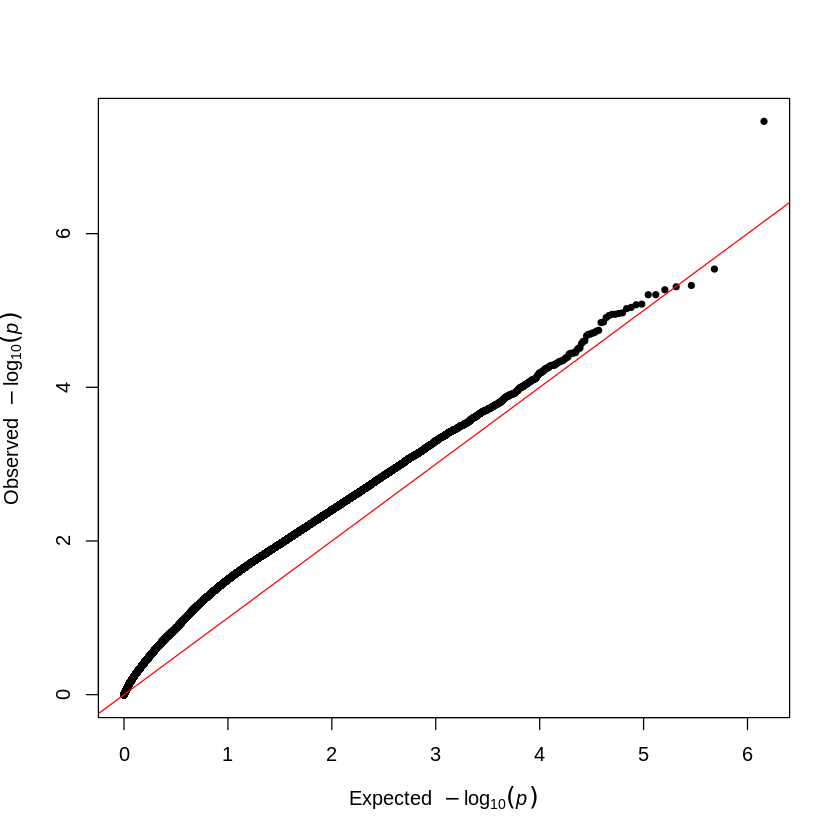

In [107]:
qqman::qq(unlinked_lrt_filt$pvalue) #if the analysis structure is correct, then most points will be a line (because the null of "no association" is true for these) and there's a tail with a higher than expected sample p value


In [108]:
#get the input file to re-run ngsld for and then rewrite the output to be space sep for chrom pos instead of colon, so I can rerun angsd including only unlinked positions
#ngsld <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_ngsLD.tsv")

System errno 22 unmapping file: Invalid argument


ERROR: Error in fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_ngsLD.tsv"): Opened 372.1GB (399516682429 bytes) file ok but could not memory map it. This is a 64bit process. There is probably not enough contiguous virtual memory available.


In [22]:
#does increasing minCount to 30 help?
mincount30 <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out_minCount30.lrt0.gz")

Warning message in fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out_minCount30.lrt0.gz"):
“Discarded single-line footer: <<CM009718.1	213>>”

In [24]:
nrow(mincount30)

[1] 3356430

In [26]:
nrow(mincount30)/nrow(case_control_lrt) #run didn't finish, but we got halfway through so hopefully that's enough to get an idea of whether it helped

[1] 0.4734893

In [27]:
mincount30[, locus := paste(Chromosome, Position, sep=":")]
no_hwe_lrt_mincount30 <- mincount30[locus %!in% case_control_hwe[p < 0.05, locus]]

#filter other sites that have negative LRT
no_hwe_lrt_filt_mincount30<-no_hwe_lrt_mincount30[LRT >0]
nrow(no_hwe_lrt_filt_mincount30) #number of sites included
no_hwe_lrt_filt_mincount30$pvalue<-dchisq(no_hwe_lrt_filt_mincount30$LRT, df=1)
summary(no_hwe_lrt_filt_mincount30$pvalue)

[1] 3346597

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.0000   0.1791   0.4805   2.1787   1.1990 398.9421 

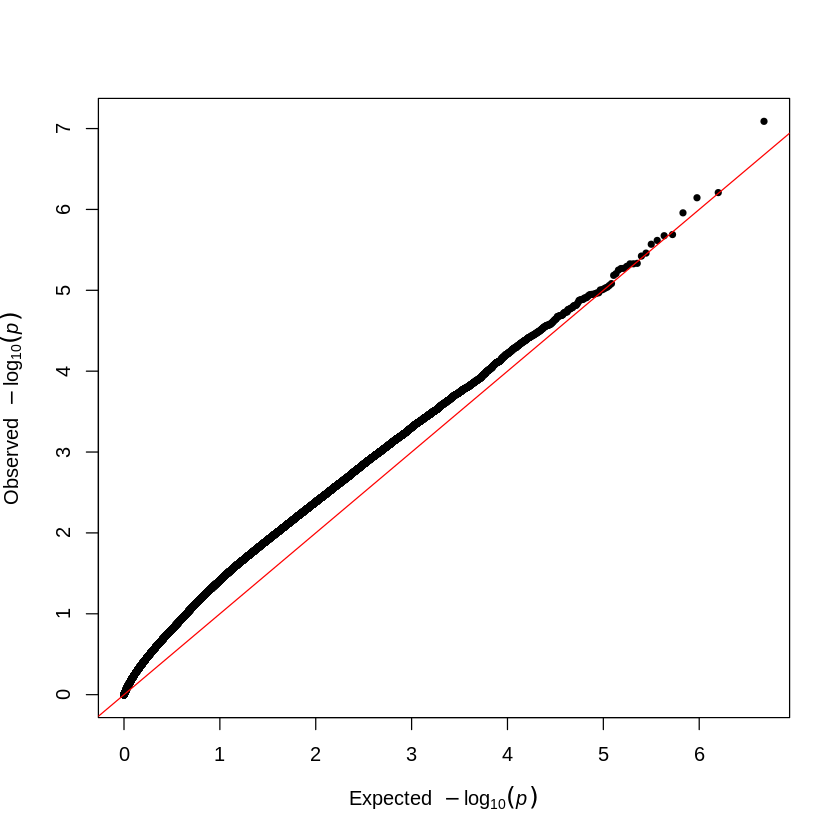

In [28]:
qq(no_hwe_lrt_filt_mincount30$pvalue) #okay no not really0 proceed with LD filtering to see if that helps

In [19]:
#hmmmm... do we have the same issues when it's with the score+EM assoc?
cc_do_assoc5 <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_doAssoc5_out.lrt0.gz")
head(cc_do_assoc5)

Chromosome,Position,Major,Minor,Frequency,N,LRTscore,high_WT/HE/HO,LRTem,beta,SE,emIter
CM009708.1,164,A,G,0.455804,159,-999,3/1/0,NaN,NaN,NaN,0
CM009708.1,479,T,A,0.434662,159,-999,3/3/0,NaN,NaN,NaN,0
CM009708.1,480,T,G,0.444954,159,-999,2/6/0,NaN,NaN,NaN,0
CM009708.1,787,C,T,0.490851,159,-999,1/3/0,NaN,NaN,NaN,0
CM009708.1,1492,T,G,0.432884,159,-999,3/3/0,NaN,NaN,NaN,0
CM009708.1,2973,C,T,0.428961,159,-999,5/3/0,NaN,NaN,NaN,0


In [20]:
summary(cc_do_assoc5$LRTscore)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -999    -999    -999    -999    -999    -999 

In [16]:
#what about SL ?
sl_assoc <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/SL_quant_assoc_out.lrt0.gz")
head(sl_assoc)

Chromosome,Position,Major,Minor,Frequency,N,LRTscore,high_WT/HE/HO,LRTem,beta,SE,emIter
CM009708.1,164,A,G,0.455804,147,-999,3/0/0,NaN,NaN,NaN,0
CM009708.1,479,T,A,0.434662,147,-999,3/2/0,NaN,NaN,NaN,0
CM009708.1,480,T,G,0.444954,147,-999,2/5/0,NaN,NaN,NaN,0
CM009708.1,787,C,T,0.490851,147,-999,1/3/0,NaN,NaN,NaN,0
CM009708.1,1492,T,G,0.432884,147,-999,3/3/0,NaN,NaN,NaN,0
CM009708.1,2973,C,T,0.428961,147,-999,4/2/0,NaN,NaN,NaN,0


In [18]:
summary(sl_assoc$LRT)

Length  Class   Mode 
     0   NULL   NULL 

In [ ]:
sl_assoc$pvalue<-dchisq(no_hwe_lrt_filt$LRT, df=1)

In [ ]:
#are these SNPs also in the SL Gwas?
#What's the highest pvalue we get with the permuted phenotypes?
#sl_lrt <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/SL_quant_assoc_out.lrt0.gz")
#sl_lrt[, locus := paste(Chromosome, Position, sep=":")]
#no_hwe_lrt_sl <- sl_lrt[locus %!in% case_control_hwe[p < 0.05, locus]]
#nrow(no_hwe_lrt) == nrow(no_hwe_lrt) #should be true

#filter other sites that have negative LRT
no_hwe_lrt_filt_sl<-no_hwe_lrt_sl[LRTscore >0]
nrow(no_hwe_lrt_filt_sl) #number of sites included
no_hwe_lrt_filt_sl$pvalue<-dchisq(no_hwe_lrt_filt_sl$LRTscore, df=1)
summary(no_hwe_lrt_filt_sl$pvalue)

In [ ]:
head(no_hwe_lrt_filt_sl[!is.na(beta)])

In [ ]:
qqnorm(no_hwe_lrt_filt_sl$pvalue)

In [ ]:
#lrt<-read.table(gzfile("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out.lrt0.gz"), header=T, sep="\t")
#setDT(lrt)
#lrt <- lrt[LRT >0]

In [ ]:
ordered <- case_control_lrt_filt[order(pvalue)]

In [ ]:
(ordered[1:100])

In [ ]:
summary(case_control_lrt_filt$pvalue)

In [ ]:
#plot maf from angsd
maf<-fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/case_control_assoc_out.mafs.gz")
setDT(maf)

In [ ]:
head(maf)

In [ ]:
hist(maf$nInd)
summary(maf$nInd)

In [ ]:
summary(maf$knownEM)
hist(maf$knownEM)

In [ ]:
library(ape)
features <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/ncbi-genomes-2022-02-28//GCA_003047355.2_Nemo_v1.1_genomic.gbff.gff", skip = 6)

In [ ]:
head(features)